# hw4 - NN pyTorch

Во всем задании вы должны работать со входом из строк размером (длиной) 1024

## Часть 1 Фурье

In [74]:
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [75]:
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


### Подготовка данных

Сгенерите данные (сигнал) любым пакетом для численного преобразования Фурье, [например](https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html#numpy.fft.fft)

In [7]:
dataset_size = 100000

In [24]:
N = 1024

x = np.linspace(0, 4, N)
freq_max = 128
freqs = np.linspace(0, freq_max, dataset_size)

In [9]:
class GeneratedDataset(Dataset):
    def __init__(self, x, freqs, func):
        self.size = len(freqs)
        self.signals = np.array([np.sin(np.pi * freq * x) for freq in freqs], dtype='float32')
        self.ffts = func(self.signals)

    def __len__(self):
        return self.size

    def __getitem__(self, index):
        return self.signals[index], self.ffts[index]

In [10]:
def fft_func(x):
    return np.abs(np.fft.fftshift(np.fft.fft(x, axis=1).real, axes=1), dtype='float32')

In [11]:
fourier_dataset = GeneratedDataset(x, freqs, fft_func)
train_length = int(dataset_size * 0.80)
test_length = int(dataset_size * 0.20)
train_dataset, test_dataset = torch.utils.data.random_split(fourier_dataset, [train_length, test_length])

### Соберите и обучите нейросетку на pyTorch для преобразования Фурье

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_samples=1024, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.linear1 = nn.Linear(num_samples, 2 * num_samples)
        self.linear2 = nn.Linear(2 * num_samples, 2 * num_samples)
        self.linear3 = nn.Linear(2 * num_samples, num_samples)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [13]:
learning_rate = 1e-3

model = NeuralNetwork().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    total_loss = 0

    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

        if batch % (batch_size * 5) == 0:
            current = batch * len(X)
            print(f"Batch {batch}, loss: {loss.item():.6f} [{current:>5d}/{size:>5d}]")

    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [15]:
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            loss = loss_fn(pred, y)
            total_loss += loss.item()

    avg_loss = total_loss / num_batches
    return avg_loss

In [16]:
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

train_losses = []
test_losses = []

epochs = 50
for t in range(epochs):
    print(f"Epoch {t + 1}\n---------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss = test_loop(test_dataloader, model, loss_fn)
    
    print(f"Train Avg Loss: {train_loss:.6f}")
    print(f"Test Avg Loss: {test_loss:.6f}")

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print("Done!")

Epoch 1
---------------------------
Batch 0, loss: 257.892487 [    0/80000]
Batch 160, loss: 128.545380 [ 5120/80000]
Batch 320, loss: 58.476250 [10240/80000]
Batch 480, loss: 29.768860 [15360/80000]
Batch 640, loss: 19.437286 [20480/80000]
Batch 800, loss: 11.436558 [25600/80000]
Batch 960, loss: 10.638737 [30720/80000]
Batch 1120, loss: 8.252258 [35840/80000]
Batch 1280, loss: 4.966819 [40960/80000]
Batch 1440, loss: 5.454271 [46080/80000]
Batch 1600, loss: 5.082321 [51200/80000]
Batch 1760, loss: 3.696612 [56320/80000]
Batch 1920, loss: 4.128241 [61440/80000]
Batch 2080, loss: 5.224035 [66560/80000]
Batch 2240, loss: 3.616086 [71680/80000]
Batch 2400, loss: 2.397951 [76800/80000]
Train Avg Loss: 25.653885
Test Avg Loss: 3.624491
Done!
Epoch 2
---------------------------
Batch 0, loss: 2.962968 [    0/80000]
Batch 160, loss: 5.132486 [ 5120/80000]
Batch 320, loss: 4.896535 [10240/80000]
Batch 480, loss: 3.532109 [15360/80000]
Batch 640, loss: 3.063850 [20480/80000]
Batch 800, loss: 3

In [19]:
torch.save({
            'epoch': 50,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, "fft_model.pt")

In [17]:
import matplotlib.pyplot as plt

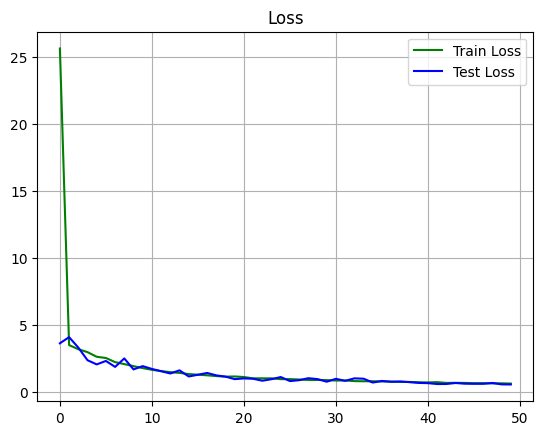

In [18]:
def plot_losses(train_losses, test_losses, epochs):
    fig, ax = plt.subplots()
    ax.set_title("Loss")

    ax.plot(np.arange(0, epochs), train_losses, color="green", label="Train Loss")
    ax.plot(np.arange(0, epochs), test_losses, color="blue", label="Test Loss")
    ax.grid()

    plt.legend()
    plt.show()


plot_losses(train_losses, test_losses, 50)

### Сравните свое решение с пакетным методом

In [25]:
X = np.array([np.sin(np.pi * np.random.choice(freqs) * x)])
y = fft_func(X)
prediction = model(torch.from_numpy(X).type(torch.float32).to(device))

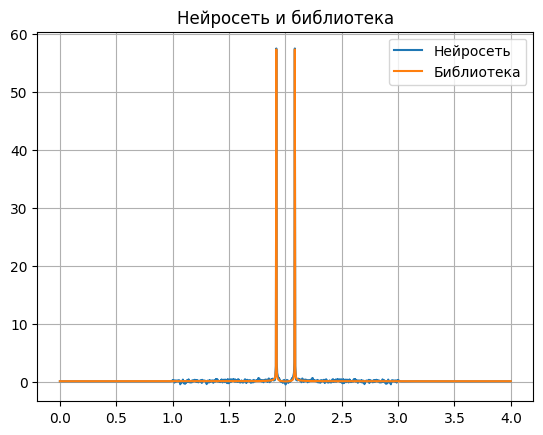

In [36]:
def plot_comparison(pred, y):
    fig, ax = plt.subplots()
    numpy_pred = pred.cpu().detach().numpy()
    
    ax.plot(x, numpy_pred[0], label="Нейросеть")
    ax.plot(x, y[0], label="Библиотека")
    
    ax.set_title("Нейросеть и библиотека")
    ax.grid()
    plt.legend()
    plt.show()


plot_comparison(prediction, y)

## Часть 2 Power spectral density (dB)

### Подготовка данных

Используя пакетное решение, [например](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html), подготовьте обучающую выборку.

In [40]:
from scipy import signal

In [132]:
class PSDDataset(Dataset):
    def __init__(self, x, freqs):
        self.size = len(freqs)
        self.signals = np.array([np.sin(np.pi * freq * x) for freq in freqs], dtype='float32')
        self.answers = signal.periodogram(self.signals, axis=1)[1]
        print(self.answers.shape)

    def __len__(self):
        return self.size

    def __getitem__(self, index):
        return self.signals[index], self.answers[index]

In [133]:
train_length = int(dataset_size * 0.80)
test_length = int(dataset_size * 0.20)

psd_dataset = PSDDataset(x, freqs)
psd_train_dataset, psd_test_dataset = torch.utils.data.random_split(psd_dataset, [train_length, test_length])

(100000, 513)


### Соберите и обучите нейросеть для предсказания спектральной плотности мощности

*Подсказка: для входа 1024 выход будет 512*

In [134]:
class PSDNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear1 = nn.Linear(1024, 2048)
        self.linear2 = nn.Linear(2048, 2048)
        self.linear3 = nn.Linear(2048, 2048)
        self.linear4 = nn.Linear(2048, 2048)
        self.linear5 = nn.Linear(2048, 2048)
        self.linear6 = nn.Linear(2048, 2048)
        self.linear = nn.Linear(2048, 513)
    
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = F.relu(self.linear4(x))
        x = F.relu(self.linear5(x))
        x = F.relu(self.linear6(x))
        return self.linear(x)

In [145]:
psd_model = PSDNet().to(device)
psd_loss_fn = nn.MSELoss()
psd_optimizer = torch.optim.Adam(psd_model.parameters(), lr=0.0001)

In [146]:
train_psd_losses = []
test_psd_losses = []

In [147]:
psd_train_loader = DataLoader(psd_train_dataset, batch_size=32, shuffle=True)
psd_test_loader = DataLoader(psd_test_dataset, batch_size=32, shuffle=True)

In [148]:
epochs = 50
for t in range(epochs):
    print(f"Epoch {t + 1}\n---------------------------")
    train_loss = train_loop(psd_train_loader, psd_model, psd_loss_fn, psd_optimizer)
    test_loss = test_loop(psd_test_loader, psd_model, psd_loss_fn)
    
    print(f"Train Avg Loss: {train_loss:.6f}")
    print(f"Test Avg Loss: {test_loss:.6f}")

    train_psd_losses.append(train_loss)
    test_psd_losses.append(test_loss)

    print("Done!")

Epoch 1
---------------------------
Batch 0, loss: 347.720947 [    0/80000]
Batch 160, loss: 357.555817 [ 5120/80000]
Batch 320, loss: 340.818939 [10240/80000]
Batch 480, loss: 298.305878 [15360/80000]
Batch 640, loss: 230.336884 [20480/80000]
Batch 800, loss: 179.848846 [25600/80000]
Batch 960, loss: 92.058052 [30720/80000]
Batch 1120, loss: 62.012108 [35840/80000]
Batch 1280, loss: 29.959227 [40960/80000]
Batch 1440, loss: 19.529625 [46080/80000]
Batch 1600, loss: 19.538828 [51200/80000]
Batch 1760, loss: 11.959040 [56320/80000]
Batch 1920, loss: 9.777767 [61440/80000]
Batch 2080, loss: 8.839686 [66560/80000]
Batch 2240, loss: 7.561145 [71680/80000]
Batch 2400, loss: 9.062594 [76800/80000]
Train Avg Loss: 118.975385
Test Avg Loss: 8.398821
Done!
Epoch 2
---------------------------
Batch 0, loss: 10.718771 [    0/80000]
Batch 160, loss: 7.760657 [ 5120/80000]
Batch 320, loss: 5.495823 [10240/80000]
Batch 480, loss: 8.493144 [15360/80000]
Batch 640, loss: 6.996845 [20480/80000]
Batch 8

In [150]:
torch.save({
            'epoch': 50,
            'model_state_dict': psd_model.state_dict(),
            'optimizer_state_dict': psd_optimizer.state_dict()
            }, "psd_model.pt")

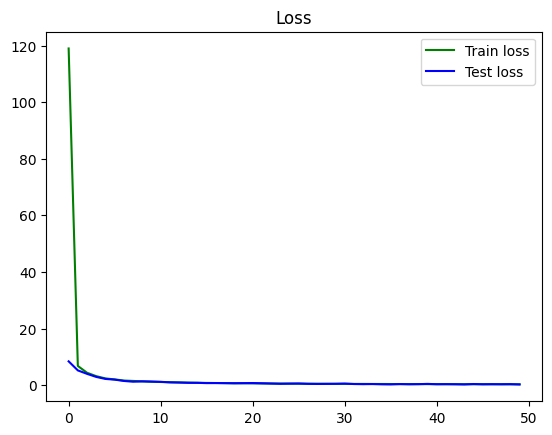

In [149]:
fig, ax = plt.subplots()
ax.set_title("Loss")
ax.plot(np.arange(0, epochs), train_psd_losses, color="green", label="Train loss")
ax.plot(np.arange(0, epochs), test_psd_losses, color="blue", label="Test loss")
plt.legend()
plt.show()

### Провалидируйте свое решение

*Примечание: Для сдачи достаточно качественного соответствия по форме спектра с пакетным решением*

In [151]:
sample = np.array([np.sin(np.pi * np.random.choice(freqs) * x)], dtype='float32')
_, psd = signal.periodogram(sample, scaling='density')
pred = psd_model(torch.tensor(sample, dtype=torch.float32).unsqueeze(0).cuda()).to('cpu')

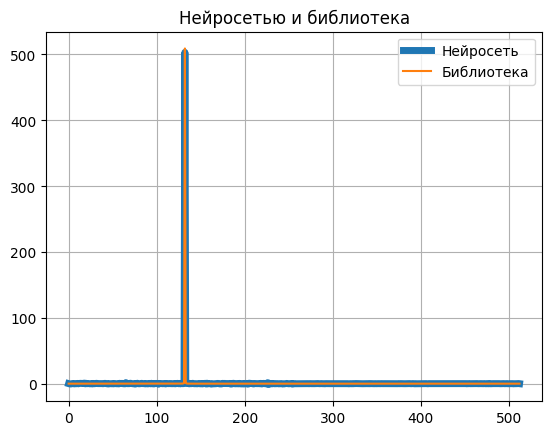

In [162]:
def plot_comparison_2(pred, y):
    fig, ax = plt.subplots()

    ax.plot(np.arange(513), pred.detach().numpy()[0][0], label="Нейросеть", linewidth=5)
    ax.plot(np.arange(513), y[0], label="Библиотека")
    ax.set_title("Нейросетью и библиотека")
    ax.grid()
    plt.legend()
    plt.show()


plot_comparison_2(pred, psd)